# PyTorch Custom Datasets

We've used some datasets with PyTorch before, but how do you get your own data into PyTorch?

In [1]:
import torch
from torch import nn

torch.__version__

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Choose Your Data

We will try and build a model working with [LiDAR data](https://en.wikipedia.org/wiki/Lidar).

I have a dataset of segmented point-cloud data, so we can take the segmented trees from a bigger LiDAR point cloud. This segmented trees are also labeled tree by tree... later we'll visualize them to better grasp their structure.

First we'll connect the notebook with Google Drive:

In [2]:
# We'll use files contained in my Gdrive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's read the .las file and turn into a numpy array.

In [3]:
las_file_path = '/content/drive/My Drive/DIFA/32_687000_4930000_FP31fS_T60_R4.0_tree.las'

In [4]:
!pip install  laspy

In [5]:
# write a function to get a np array from las files
import numpy as np
import laspy

def read_las_file_to_numpy(file_path, features_to_extract=None):
    """
    Reads a LAS file, extracts coordinate data (x, y, z), specific features and labels,
    and returns them as a numpy array.

    Parameters:
    - file_path (str): The path to the LAS file.
    - features_to_extract (list): List of features to extract from the LAS file.

    Returns:
    - np.ndarray: A numpy array containing the extracted data from the LAS file.
    - feature_names (list of str): List of feature names corresponding to the columns in the array.
    """
    # Read the LAS file
    print(f"Processing {file_path}...")
    las_data = laspy.read(file_path)

    # Initialize a list to store the features and their names
    data = []

    # Check if x, y, z coordinates are present
    if hasattr(las_data, 'x') and hasattr(las_data, 'y') and hasattr(las_data, 'z'):
        if len(las_data.x) > 0 and len(las_data.y) > 0 and len(las_data.z) > 0:
            # Add x, y, z as the first columns
            data.append(las_data.x)
            data.append(las_data.y)
            data.append(las_data.z)
        else:
            print(f"Warning: One of the coordinate arrays (x, y, z) is empty in {file_path}.")
            return None
    else:
        print(f"Warning: LAS data in {file_path} does not have 'x', 'y', or 'z' attributes.")
        return None

    # Extract additional features
    available_features = []
    missing_features = []
    for feature in features_to_extract:
        if feature in ['x', 'y', 'z']:
            continue  # Skip if feature is x, y, or z since they are already added
        if feature in las_data.point_format.dimension_names:
            data.append(las_data[feature])
            available_features.append(feature)
        else:
            missing_features.append(feature)

    # Warn if any requested features are missing
    if missing_features:
        print(f"Warning: The following features were not found in the LAS file: {missing_features}")

    # Add selected features to feature_names
    feature_names = ['x', 'y', 'z']
    feature_names += available_features

    # Convert the data list to a numpy array and transpose to match the expected shape (N, num_features)
    data_array = np.vstack(data).T
    print(f"Loaded NumPy array with shape: {data_array.shape}")

    return data_array, feature_names


In [6]:
features_to_extract = ['x', 'y', 'z', 'tree']

np_points, feature_names = read_las_file_to_numpy(las_file_path, features_to_extract=features_to_extract)

Processing /content/drive/My Drive/DIFA/32_687000_4930000_FP31fS_T60_R4.0_tree.las...
Loaded NumPy array with shape: (55569, 4)


In [7]:
print(f"Tree point cloud stored as np with {np_points.shape[0]} points. \nVector shape: {np_points.shape}")

Tree point cloud stored as np with 55569 points. 
Vector shape: (55569, 4)


In [8]:
import pandas as pd

df = pd.DataFrame(np_points, columns=feature_names)

print(f"{df.head()} \n")
print(f"{df.info()} \n")
print(f"shape: {df.shape} \n \n")
print(df.describe())

           x           y      z  tree
0  687276.90  4930057.06  49.33  13.0
1  687276.88  4930056.83  49.37  13.0
2  687276.84  4930056.60  49.37  13.0
3  687276.82  4930056.36  49.37  13.0
4  687276.79  4930056.12  49.34  13.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55569 entries, 0 to 55568
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       55569 non-null  float64
 1   y       55569 non-null  float64
 2   z       55569 non-null  float64
 3   tree    55569 non-null  float64
dtypes: float64(4)
memory usage: 1.7 MB
None 

shape: (55569, 4) 
 

                   x             y             z          tree
count   55569.000000  5.556900e+04  55569.000000  55569.000000
mean   687263.807906  4.930092e+06     56.148522     11.603592
std         7.615527  2.676064e+01      3.953389      7.434070
min    687243.420000  4.930047e+06     46.720000      1.000000
25%    687258.800000  4.930068e+06     52.980000      5.

Let's write a function to visualize these points:

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_point_cloud_scaled(np_points, save=False, file_path=None):
    """
    Plots a 3D scatter plot of a point cloud with equal scaling for all axes.

    Args:
    - np_points (np.ndarray): N x 3 or N x F numpy array, with at least x, y, z in the first 3 columns.
    - save (bool): If True, saves the plot to file.
    - file_path (str): Path to save the plot (only if save is True).
    """
    x = np_points[:, 0]
    y = np_points[:, 1]
    z = np_points[:, 2]
    tree = np_points[:, -1]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=tree, cmap='viridis', s=0.2)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0

    mid_x = (x.max() + x.min()) * 0.5
    mid_y = (y.max() + y.min()) * 0.5
    mid_z = (z.max() + z.min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    if save and file_path:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        plt.savefig(file_path)
        plt.close()
    else:
        plt.show()


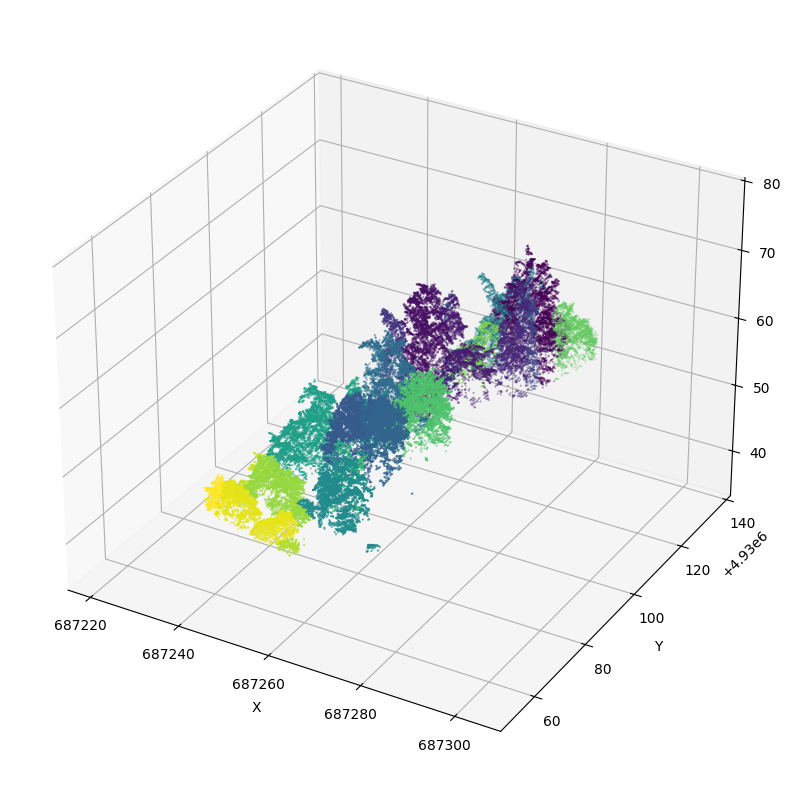

In [10]:
plot_point_cloud_scaled(np_points)

How about some more files?

Processing /content/drive/My Drive/DIFA/32_687000_4930000_FP31fS_T30_R7.5_tree.las...
Loaded NumPy array with shape: (25255, 4)


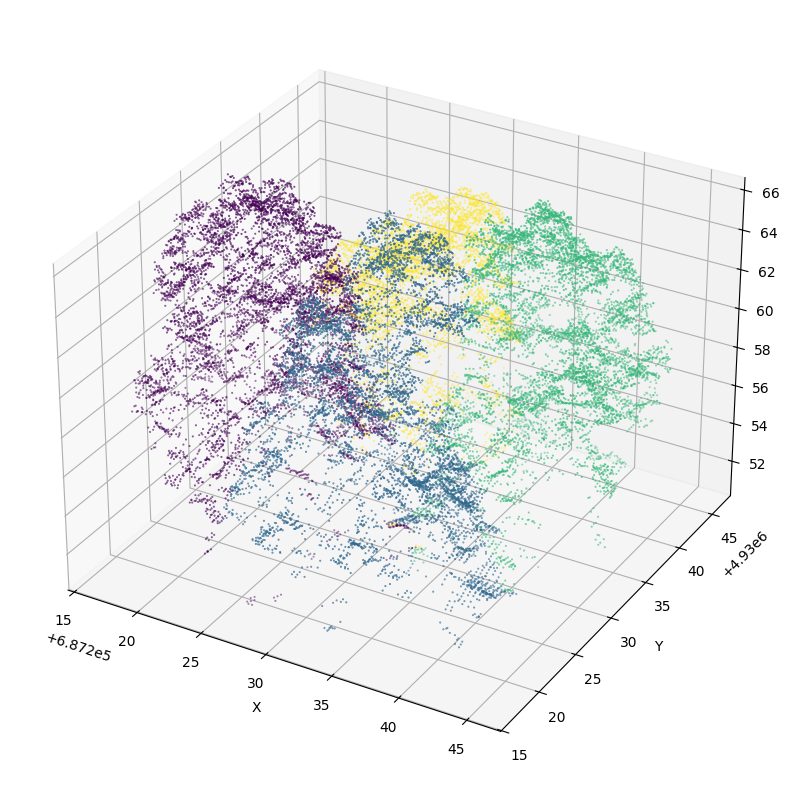

In [11]:
las_file_path2 = '/content/drive/My Drive/DIFA/32_687000_4930000_FP31fS_T30_R7.5_tree.las'

np_points2, feature_names2 = read_las_file_to_numpy(las_file_path2, features_to_extract=features_to_extract)

plot_point_cloud_scaled(np_points2)

Processing /content/drive/My Drive/DIFA/32_687000_4930000_FP31fS_T25_R4.0_tree.las...
Loaded NumPy array with shape: (66142, 4)


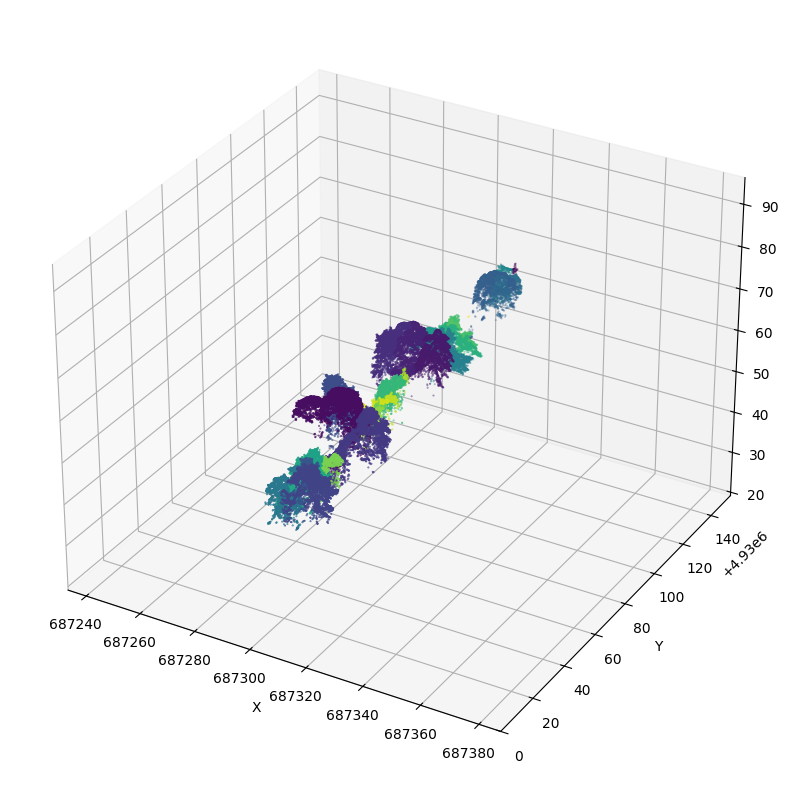

In [12]:
las_file_path3 = '/content/drive/My Drive/DIFA/32_687000_4930000_FP31fS_T25_R4.0_tree.las'

np_points3, feature_names3 = read_las_file_to_numpy(las_file_path3, features_to_extract=features_to_extract)

plot_point_cloud_scaled(np_points3)

Alright, now we may want to split the data into training and test data, right?

Since our data already has a "structure" itself - its divided into trees - we might want to divide between training trees and test trees.

Let's start by fusing together all our tree files

In [13]:
# remove all "0" trees (trees with few points)
np_points = np_points[np_points[:, -1] > 0]
np_points2 = np_points2[np_points2[:, -1] > 0]
np_points3 = np_points3[np_points3[:, -1] > 0]

# get all unique indices
first_tree_indices = np.unique(np_points[:,-1])
print(f"{first_tree_indices}")

second_tree_indices = np.unique(np_points2[:,-1])
print(f"{second_tree_indices}")

third_tree_indices = np.unique(np_points3[:,-1])
print(f"{third_tree_indices}")

# refactor indices from 0 to max
start_idx_1 = len(first_tree_indices)

np_points2[:, -1] += start_idx_1

start_idx_2 = len(first_tree_indices) + len(second_tree_indices)

np_points3[:, -1] += start_idx_2

print(np.unique(np_points2[:, -1]))
print(np.unique(np_points3[:, -1]))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26.]
[1. 2. 3. 4.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
[27. 28. 29. 30.]
[31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.
 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60.]


In [14]:
# fuse all in one vector now that the indexing allows it
all_points = np.vstack((np_points, np_points2, np_points3))

print(all_points[70000:70010])

[[6.87226790e+05 4.93003367e+06 6.32500000e+01 3.00000000e+01]
 [6.87226760e+05 4.93003345e+06 6.31300000e+01 3.00000000e+01]
 [6.87226480e+05 4.93003340e+06 6.21300000e+01 3.00000000e+01]
 [6.87226460e+05 4.93003317e+06 6.20600000e+01 3.00000000e+01]
 [6.87225290e+05 4.93003315e+06 5.69900000e+01 2.70000000e+01]
 [6.87226460e+05 4.93003293e+06 6.20400000e+01 3.00000000e+01]
 [6.87225340e+05 4.93003292e+06 5.70400000e+01 2.70000000e+01]
 [6.87225320e+05 4.93003267e+06 5.69900000e+01 2.70000000e+01]
 [6.87225660e+05 4.93003238e+06 5.83400000e+01 2.70000000e+01]
 [6.87225320e+05 4.93003242e+06 5.69800000e+01 2.70000000e+01]]


In [15]:
print(np.unique(all_points[:, -1]))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60.]


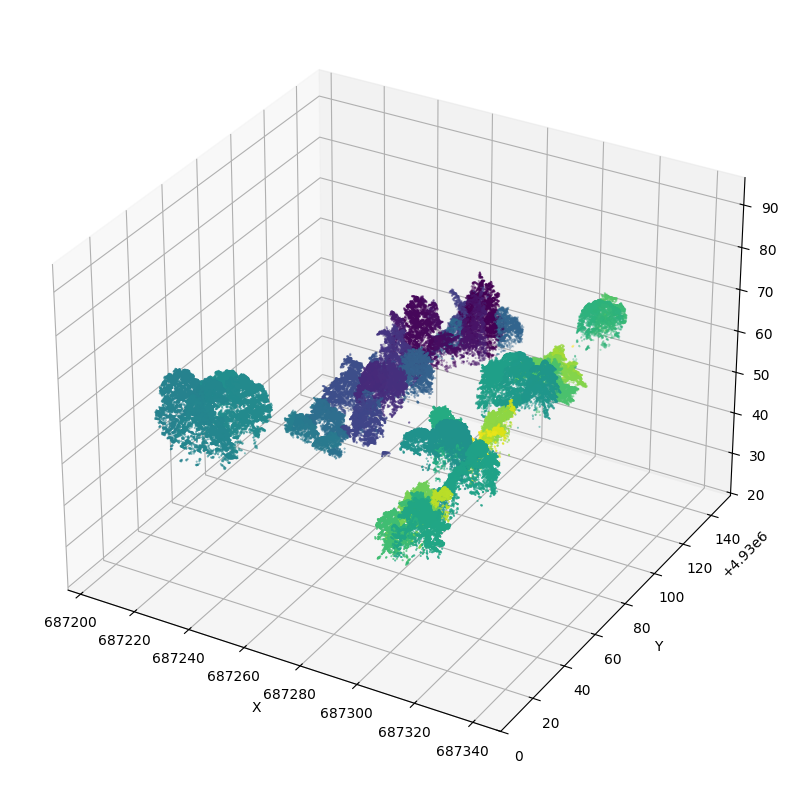

In [16]:
plot_point_cloud_scaled(all_points)

## 2. Train / Test Split & Saving

Now let's split data nto training and test.

Our task now is **unsupervised learning** (we are not going to use labels) so we will only have `X` and `y`.

In [39]:
from sklearn.model_selection import train_test_split

random_seed = 42

tree_ids = np.unique(all_points[:, -1])

# split trees into train/test
train_tree_ids, test_tree_ids = train_test_split(tree_ids, test_size=0.2, random_state=42)

X = all_points[np.isin(all_points[:, -1], train_tree_ids)]  # get all trees that have train tree ids
y = all_points[np.isin(all_points[:, -1], test_tree_ids)]   # get all trees that have test tree ids


> **Note:** When splitting LiDAR point cloud data for training and testing, it's important to split by **trees**, not by **points**. If points are randomly split, points from the same tree can appear in both the training and testing sets. This leads to **data leakage**, where the model sees part of the test data during training, resulting in overly optimistic evaluation metrics. By splitting based on trees, we ensure that entire trees are either in the training set or in the test set, preventing data leakage and providing a true measure of generalization to unseen trees.


In [40]:
print(f"All points shape: {all_points.shape} | X shape: {X.shape} | y shape: {y.shape}\n")
print(f"X examples: \n{X[100:110]} \n\nY examples: \n{y[20:30]}")

All points shape: (146916, 4) | X shape: (116361, 4) | y shape: (30555, 4)

X examples: 
[[6.87274340e+05 4.93006365e+06 5.98000000e+01 9.00000000e+00]
 [6.87273750e+05 4.93006373e+06 5.72000000e+01 9.00000000e+00]
 [6.87273970e+05 4.93007078e+06 5.50000000e+01 9.00000000e+00]
 [6.87273920e+05 4.93007057e+06 5.49100000e+01 9.00000000e+00]
 [6.87274850e+05 4.93006991e+06 5.95700000e+01 9.00000000e+00]
 [6.87274830e+05 4.93006971e+06 5.94800000e+01 9.00000000e+00]
 [6.87274780e+05 4.93006949e+06 5.93800000e+01 9.00000000e+00]
 [6.87273670e+05 4.93006966e+06 5.44700000e+01 9.00000000e+00]
 [6.87274700e+05 4.93006925e+06 5.92300000e+01 9.00000000e+00]
 [6.87273620e+05 4.93006944e+06 5.44400000e+01 9.00000000e+00]] 

Y examples: 
[[6.87276120e+05 4.93005642e+06 5.35800000e+01 1.30000000e+01]
 [6.87276120e+05 4.93005620e+06 5.39600000e+01 1.30000000e+01]
 [6.87276100e+05 4.93005597e+06 5.39800000e+01 1.30000000e+01]
 [6.87275440e+05 4.93005346e+06 5.22200000e+01 1.30000000e+01]
 [6.87275820e

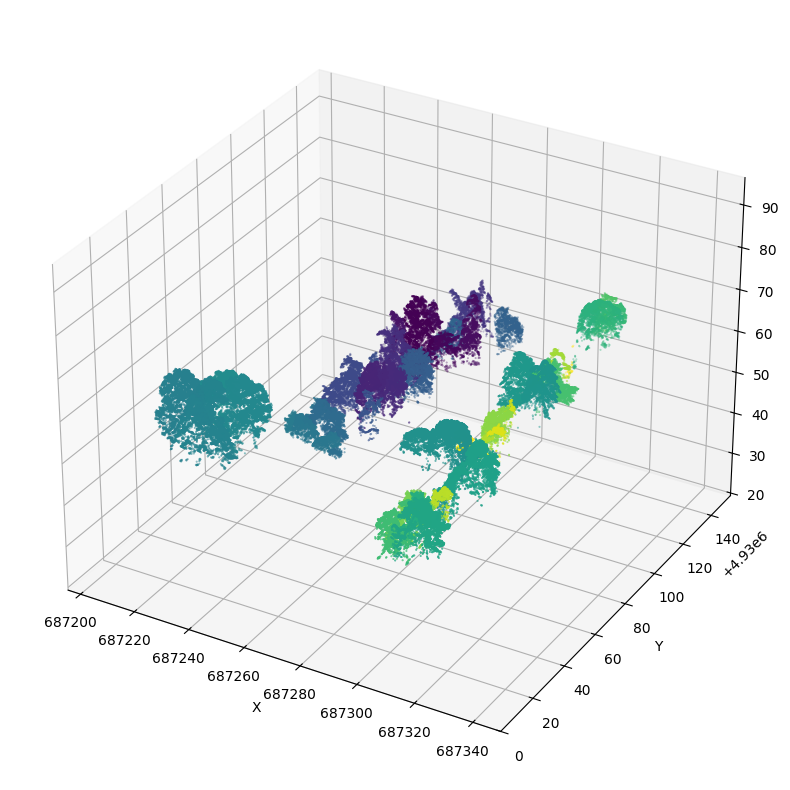

In [43]:
plot_point_cloud_scaled(X)

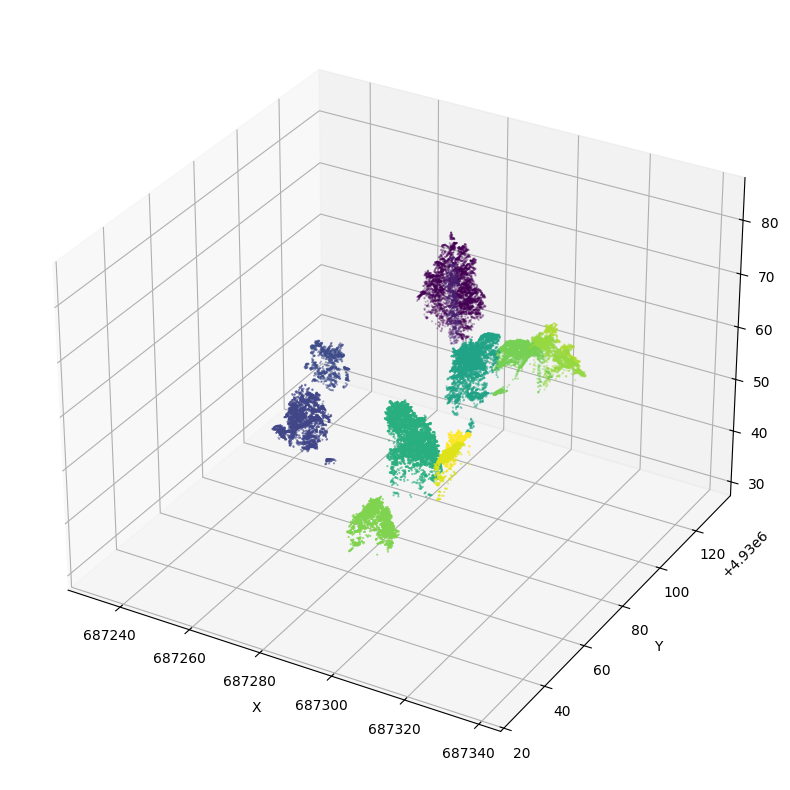

In [44]:
plot_point_cloud_scaled(y)

Now we could also save this data in order to use it later on for further experimentation.

In [41]:
# save it locally:
from pathlib import Path

save_path = Path('data/')

Path(save_path).mkdir(parents=True, exist_ok=True)

np.save(save_path / 'train_data.npy', X)
np.save(save_path / 'test_data.npy', y)

In [42]:
# save it to drive as well

drive_path = Path('/content/drive/MyDrive/DIFA/data')

Path(drive_path).mkdir(parents=True, exist_ok=True)

np.save(drive_path / 'train_data.npy', X)
np.save(drive_path / 'test_data.npy', y)

## 3. Turn Data into a `Dataloader`

Before we can use our data in PyTorch we need to:
1. Turn the data into tensors;
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`.

In [30]:
from pathlib import Path

save_path = Path('data/')

# Let's load our saved data
X = np.load(save_path / "train_data.npy")
y = np.load(save_path / "test_data.npy")

print(f"X examples: \n{X[100:110]} \n\nY examples: \n{y[20:30]}")

# turn arrays into tensors
X = torch.from_numpy(X)
y = torch.from_numpy(y)

X examples: 
[[6.87326670e+05 4.93000242e+06 6.15400000e+01 3.60000000e+01]
 [6.87267040e+05 4.93009208e+06 5.76200000e+01 1.90000000e+01]
 [6.87302080e+05 4.93010130e+06 5.76900000e+01 4.60000000e+01]
 [6.87275170e+05 4.93012534e+06 5.99000000e+01 1.00000000e+00]
 [6.87321310e+05 4.93004623e+06 5.97700000e+01 3.50000000e+01]
 [6.87263130e+05 4.93013523e+06 5.52600000e+01 1.10000000e+01]
 [6.87247360e+05 4.93005855e+06 5.04900000e+01 2.40000000e+01]
 [6.87301440e+05 4.93008906e+06 6.30100000e+01 3.40000000e+01]
 [6.87313900e+05 4.93001957e+06 5.82100000e+01 4.80000000e+01]
 [6.87300870e+05 4.93009014e+06 6.60600000e+01 3.40000000e+01]] 

Y examples: 
[[6.87224720e+05 4.93003034e+06 6.29000000e+01 2.70000000e+01]
 [6.87310650e+05 4.93010222e+06 5.97100000e+01 4.30000000e+01]
 [6.87305210e+05 4.93004217e+06 6.63900000e+01 3.10000000e+01]
 [6.87266260e+05 4.93006609e+06 6.29200000e+01 8.00000000e+00]
 [6.87262050e+05 4.93011097e+06 6.27500000e+01 7.00000000e+00]
 [6.87307300e+05 4.9300535

In [31]:
print(f"X: {X} \ny: {y}")

X: tensor([[6.8726e+05, 4.9301e+06, 5.8320e+01, 1.1000e+01],
        [6.8726e+05, 4.9301e+06, 5.7360e+01, 2.0000e+00],
        [6.8727e+05, 4.9301e+06, 5.8770e+01, 1.0000e+00],
        ...,
        [6.8731e+05, 4.9301e+06, 6.0250e+01, 3.2000e+01],
        [6.8730e+05, 4.9301e+06, 5.8470e+01, 4.5000e+01],
        [6.8731e+05, 4.9300e+06, 5.2520e+01, 4.7000e+01]], dtype=torch.float64) 
y: tensor([[6.8724e+05, 4.9300e+06, 6.2430e+01, 2.9000e+01],
        [6.8724e+05, 4.9300e+06, 6.5050e+01, 2.9000e+01],
        [6.8731e+05, 4.9301e+06, 6.3060e+01, 3.2000e+01],
        ...,
        [6.8732e+05, 4.9300e+06, 5.8540e+01, 3.8000e+01],
        [6.8722e+05, 4.9300e+06, 6.4190e+01, 2.7000e+01],
        [6.8730e+05, 4.9301e+06, 6.1190e+01, 3.4000e+01]], dtype=torch.float64)


In [34]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32

WORKERS = os.cpu_count()  # for num workers
print(f"{WORKERS} usable workers")

train_dataloader = DataLoader(dataset=X,
                              batch_size=BATCH_SIZE,
                              num_workers=WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=y,
                              batch_size=BATCH_SIZE,
                              num_workers=WORKERS,
                              shuffle=False)


2 usable workers


> **Note:**  
> The `num_workers` parameter in a PyTorch `DataLoader` specifies how many subprocesses to use for data loading.  
>
> - `num_workers=0`: data loading is done in the main process (default, safer for debugging).  
> - `num_workers>0`: data loading is done in the background with multiple workers, which can **speed up** the data loading especially when you have large datasets or complex preprocessing.
>
> **Tip:** Start with a small number like `2` or `4` and increase it based on your CPU capacity. Too high a value might cause instability or out-of-memory errors.


## 4. Creating a Custom Dataset Class

Sometimes `torch` will provide us with pre-built `Dataset` class, but in general for custom data these won't be available.

So we need to write our own `Dataset` class, able to load data.

### 4.1 Best Practices for Writing a Custom `Dataset` in PyTorch

When working with custom data formats like LiDAR point clouds, it’s essential to define a clean and efficient `Dataset` class. The best practice is to inherit from `torch.utils.data.Dataset`(https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and implement three key methods:

- **`__init__`**: Load file paths or data arrays. For smaller datasets (that fit in memory), you can load the full data here. For very large datasets, you might prefer *lazy loading* inside `__getitem__`.
- **`__len__`**: Return the number of samples available in the dataset.
- **`__getitem__`**: Fetch a single sample by its index. This is where you select one point (or group of points) and convert it to a PyTorch tensor using `torch.from_numpy`.

It’s a good idea to perform any normalization or standardization here if you haven't pre-processed your data. Optionally, you can add a `transform` argument to the `Dataset` class to apply augmentations (like random rotations or jittering), making your model more robust.

For LiDAR data, where point clouds can be extremely large, **memory mapping** (`mmap_mode='r'` in NumPy) can be a useful trick to avoid loading the entire dataset into memory at once. This keeps the file on disk and accesses data only when needed, trading off speed for reduced memory usage.

Following these guidelines ensures your dataset will work seamlessly with PyTorch's `DataLoader` and allow for scalable, efficient training even on large 3D datasets.


In [38]:
from torch.utils.data import Dataset

# subclass Dataset
class LidarTreeDataset(Dataset):
  # initialize custom dataset
  def __init__(self,
               points_file,
               transform=None):
    """
    Custom Dataset for Lidar Tree Points.

    Args:
        points_file (str or Path): Path to the .npy file containing points.
        labels_file (str or Path): Path to the .npy file containing labels.
        transform (callable, optional): Optional transform to apply on a sample.
    """

    # create class attributes
    self.points = np.load(points_file)
    self.transform = transform

  # overwrite __len()__ (required)
  def __len__(self):
    return len(self.points)

  # overwrite __get_item()__  (required)
  def __get_item__(self, idx):
    point= self.points[idx]

    # Apply optional transforms when you use get item
    if self.transform:
        point = self.transform(point)

    return point

## 5. Create Data Transforms

Applying data transforms to LiDAR point cloud data before feeding it into a neural network is crucial for effective learning and generalization. Raw point clouds often have properties — such as large coordinate values, variable scales, and arbitrary orientations — that can make the learning process unstable or harder for the model to generalize.

Common and recommended transformations include:

- **Centering**: Subtracting the centroid (mean of x, y, z) of each point cloud centers it at the origin. This removes dependence on absolute position and focuses the model on learning the shape of the object.
- **Normalization**: Scaling the point cloud to fit within a unit sphere or unit cube standardizes the scale across different samples. This prevents larger objects from dominating the training process and stabilizes optimization.
- **Random Rotation**: Randomly rotating point clouds, especially around the vertical axis, makes the model invariant to object orientation. This is particularly useful when orientation carries no important meaning, as is often the case with natural objects like trees.
- **Adding Noise (Jittering)**: Introducing small random perturbations to the point coordinates can improve robustness to sensor noise and prevent overfitting.
- **Downsampling**: Reducing the number of points to a fixed size ensures consistent input dimensions for the network, making batching and training more efficient. Care must be taken to preserve enough points to represent the object accurately.

Overall, these transformations make the learning problem easier by standardizing the data and simulating real-world variations. They help the network learn more general and robust features, leading to better performance on unseen point clouds.